In [1]:
# Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split #serpara los datos 
from sklearn.metrics import confusion_matrix, classification_report #estos los regulatado las claisigfacion y la matriz de confusion
from sklearn.preprocessing import StandardScaler #normalizar los datos 

In [2]:

def to_classlabel(z):
    return z.argmax(axis = 1) #etiqeuta en la columna



In [3]:
#y susecion de numeros, 
# def one_hot_encode(y):
#     n_class = np.unique(y).shape[0] #cunatas clases tiene Y 
#     y_encode = np.zeros((y.shape[0], n_class)) #inicialzia la tabla, rengloes(instancias ) columnas numero de clases
#     for idx, val in enumerate(y):
#         y_encode[idx, val] = 1.0
#     return y_encode

def one_hot_encode(y):
    n_class = np.unique(y).shape[0]
    y_encode = np.zeros((y.shape[0], n_class))
    for idx, val in enumerate(y):
        y_encode[idx, val] = 1.0
    return y_encode

In [4]:
# Define Accuracy
def accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred) / len(y_true)
    return acc #presicion 


In [ ]:
class Softmax_Regression_GDX():
    
    def __init__(self, lambda_param=0.01):
        self.theta = None
        self.lambda_param = lambda_param  # Parámetro de regularización L2
        
    
    def _softmax(self, Z):
        shiftZ = Z - np.max(Z, axis=1, keepdims=True)
        expZ = np.exp(shiftZ)
        return expZ / np.sum(expZ, axis=1, keepdims=True)



    #fiunciond e cosot binaria 
    def _loss(self, Y, h):

        epsilon = 1e-10  # Para evitar log(0)
        m = Y.shape[0]

        loss = -np.sum(Y * np.log(np.clip(h, epsilon, 1 - epsilon))) / m
        reg_term = (self.lambda_param / (2 * m)) * np.sum(self.theta[1:, :]**2)
        return loss + reg_term

    def fit(self, A, y, learning_rate=0.01, momentum=0.9, 
            lr_dec=0.5, lr_inc=1.05, max_perf_inc=1.04,
            epochs=100, batch_size=32, show_step=10, 
            stopping_threshold=1e-6, verbose=False):
        
        Y = one_hot_encode(y)
        n_classes = Y.shape[1]
        n_features = A.shape[1]
        

        self.theta = np.random.randn(n_features, n_classes) * 0.01
        delta_theta = np.zeros_like(self.theta)
        n_obs = A.shape[0]
        lr = learning_rate
        previous_loss = np.inf
        epoch_loss = []
        
        for e in range(epochs + 1):
            THETA_prev = self.theta.copy()
            loss_e = 0
            
            indices = np.random.permutation(n_obs)
            A_shuffled = A[indices]
            Y_shuffled = Y[indices]
            
            n_batches = n_obs // batch_size
            residual = n_obs % batch_size
            total_batches = n_batches + (1 if residual != 0 else 0)
            
            for batch_idx in range(total_batches):
                start = batch_idx * batch_size
                end = start + batch_size
                if batch_idx == n_batches and residual != 0:
                    end = start + residual
                
                A_batch = A_shuffled[start:end]
                Y_batch = Y_shuffled[start:end]

                #modificacion para lotes : 

                if fit_params['batch_size'] == len(y_train):  # Solo para batch completo
                    dropout_mask = np.random.binomial(1, 0.7, size=A_batch.shape)
                    A_batch = A_batch * dropout_mask
                
                Z_batch = A_batch @ self.theta
                S_batch = self._softmax(Z_batch)
                loss_batch = self._loss(Y_batch, S_batch)
                loss_e += loss_batch
                
                grad = (1 / len(A_batch)) * A_batch.T @ (S_batch - Y_batch)
                grad[1:, :] += (self.lambda_param / len(A_batch)) * self.theta[1:, :]
                
                delta_theta = momentum * delta_theta - (1 - momentum) * lr * grad
                self.theta += delta_theta
            
            avg_loss = loss_e / total_batches
            if avg_loss > previous_loss * max_perf_inc:
                self.theta = THETA_prev
                lr *= lr_dec
            elif avg_loss < previous_loss:
                lr *= lr_inc
            
            epoch_loss.append(avg_loss)
            
            if abs(previous_loss - avg_loss) < stopping_threshold:
                if verbose:
                    print(f"Early stopping at epoch {e}")
                break
            
            previous_loss = avg_loss
            
            if verbose and e % show_step == 0:
                print(f'Epoch: {e}, Loss: {avg_loss:.3e}, lr: {lr:.2e}')
        
        return epoch_loss
                
    def predict(self, A):
        Z = A @ self.theta
        S = self._softmax(Z)
        return np.argmax(S, axis=1)




In [6]:


# # Read the data
# data = np.loadtxt('admisiones_dataset.txt',delimiter=',')
# inputs = data[:,0:2]
# idx = 2-data[:,2] #restamos el 1 para establecer el categorico, adminitivos - 1 no admitivos - 0 
# targets = np.array(idx, dtype=int)     # codificacion categorica
# # targets = one_hot_encode(labels)      # one hot encode to classlabel


# Cargar datos usando el formato especificado
try:
    # Intenta leer como archivo de texto
    data = np.loadtxt('cancer_dataset.dat', delimiter=',')
except:
    # Intenta leer como binario si falla
    data = np.fromfile('cancer_dataset.dat', dtype=np.float32)
    # Ajustar según la estructura de tus datos (30 características + 1 etiqueta)
    data = data.reshape((-1, 31))

# Procesamiento de datos
inputs = data[:, :-1]
targets = data[:, -1].astype(int)



In [7]:

# Split the data
# x_train,x_test,y_train,y_test = train_test_split(inputs,targets,test_size=0.40,random_state=1234) # test_size genreta entrenamiento y prueba 

# División de datos
x_train, x_test, y_train, y_test = train_test_split(
    inputs, targets, test_size=0.3, random_state=42
)


In [8]:
# Normalización
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)



In [9]:
#matrices de disenio, 
A_train = np.c_[np.ones(len(x_train)), x_train]
A_test  = np.c_[np.ones(len(x_test)), x_test]


In [10]:
# Parámetros para el constructor



#online
# lambda_param = 0.1  
# fit_params = {
#     'learning_rate': 1e-3,
#     'momentum': 0.95,
#     'lr_dec': 0.5,
#     'lr_inc': 1.05,
#     'max_perf_inc': 1.04,
#     'epochs': 1000,
#     'batch_size': 1,
#     'show_step': 100,
#     'stopping_threshold': 1e-6,
#     'verbose': True
# }


#minilonte

# lambda_param = 0.01 
# fit_params = {
#     'learning_rate': 0.01,
#     'momentum': 0.95,
#     'lr_dec': 0.5,
#     'lr_inc': 1.05,
#     'max_perf_inc': 1.04,
#     'epochs': 1000,
#     'batch_size': 64,
#     'show_step': 100,
#     'stopping_threshold': 1e-6,
#     'verbose': True
# }

#lote

lambda_param = 0.1 
fit_params = {
    'learning_rate': 1e-3,
    'momentum': 0.95,
    'lr_dec': 0.5,
    'lr_inc': 1.05,
    'max_perf_inc': 1.04,
    'epochs': 500,
    'batch_size': len(y_train),
    'show_step': 50,
    'stopping_threshold': 1e-4,
    'verbose': True
}

In [11]:

# # Build and fit best LR model
# alpha = 0.01 #lr
# maxEpochs = 5000
# batch = 10 #minilotes
# show = 500 #view

# # Build model
# log_model = Logistic_Regression()
# # Fit Model
# theta, batch_loss, epoch_loss = log_model.fit(A_train, y_train, learning_rate=alpha, 
#                                 epochs=maxEpochs, batch_size=batch, show_step = show, verbose=True)


# Entrenamiento del modelo
model = Softmax_Regression_GDX(lambda_param=lambda_param)
loss_history = model.fit(A_train, y_train, **fit_params)


Epoch: 0, Loss: 7.119e-01, lr: 1.05e-03
Epoch: 50, Loss: 6.084e-01, lr: 1.04e-02
Epoch: 100, Loss: 2.136e-01, lr: 1.14e-01
Epoch: 150, Loss: 1.083e-01, lr: 1.04e-04
Epoch: 200, Loss: 9.166e-02, lr: 1.27e-09
Epoch: 250, Loss: 9.629e-02, lr: 8.64e-15
Epoch: 300, Loss: 8.852e-02, lr: 5.58e-20
Early stopping at epoch 330


In [12]:
# Predicciones y evaluación
# Predicciones
train_pred = model.predict(A_train)
test_pred = model.predict(A_test)


In [14]:
# # Calculate accuracy
# train_acc = accuracy(y_train, train_pred)
# print(f'Accuracy on training set: {train_acc}')
#resultados finales
print("\nresultados en conjunto de entrenamiento:")
print(f'Accuracy: {accuracy(y_train, train_pred):.4f}')
print("matriz de confusion:")
print(confusion_matrix(y_train, train_pred))
print("\nreporte de clasificacion:")
print(classification_report(y_train, train_pred))


resultados en conjunto de entrenamiento:
Accuracy: 0.9796
matriz de confusion:
[[318  10]
 [  0 161]]

reporte de clasificacion:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       328
           1       0.94      1.00      0.97       161

    accuracy                           0.98       489
   macro avg       0.97      0.98      0.98       489
weighted avg       0.98      0.98      0.98       489



In [15]:
print("\nresultados en conjunto de prueba:")
print(f'Accuracy: {accuracy(y_test, test_pred):.4f}')
print("\nmatriz de confusion:")
print(confusion_matrix(y_test, test_pred))
print("\nreporte de clasificacion:")
print(classification_report(y_test, test_pred))




resultados en conjunto de prueba:
Accuracy: 0.9857

matriz de confusion:
[[128   2]
 [  1  79]]

reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       130
           1       0.98      0.99      0.98        80

    accuracy                           0.99       210
   macro avg       0.98      0.99      0.98       210
weighted avg       0.99      0.99      0.99       210



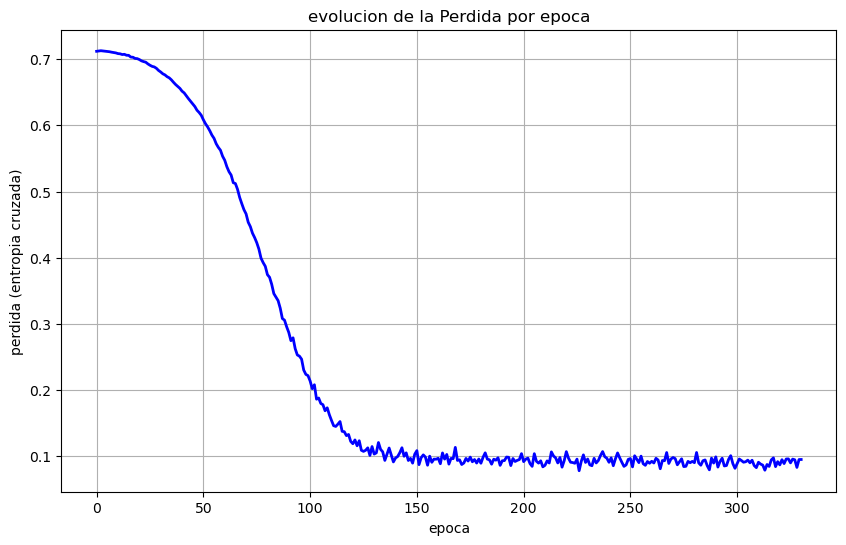

In [16]:

# Gráfica de pérdida
# Gráfica de pérdida
plt.figure(figsize=(10, 6))
plt.plot(loss_history, 'b-', linewidth=2)
plt.title('evolucion de la Perdida por epoca')
plt.xlabel('epoca')
plt.ylabel('perdida (entropia cruzada)')
plt.grid(True)
plt.show()
